In [53]:
import sys, getopt, os.path
import matplotlib.pyplot as plt
import numpy as np

import math,h5py, pandas
from scipy import integrate
from scipy.fftpack import fft, hilbert
from scipy.signal import butter, lfilter
from geopy.distance import great_circle
import matplotlib.ticker as ticker
import yaml
import netCDF4 as nc

import pandas as pd
import time
import copy

In [54]:
flag_project = 1

if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
#name_project = 'project_repartition_v4.0/output_repar_v9.5_01--10-16Hz/'

In [55]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  ./
dir_project_workspace:  ./
dir_project:  ./project_repartition_v4.0/output_repar_v9.5_02--10-16Hz/


In [56]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [57]:
dir_image = dir_project + info_basic['rdir_image']+'model_validate/'
dir_partition = dir_project + info_basic['rdir_partition']
dir_disp = dir_project + info_basic['rdir_disp_model']
if not os.path.exists(dir_image):
    os.makedirs(dir_image)
#dir_CC = os.getcwd()+'/'+dir_CC_workspace[1:] + info_basic['rdir_CC']
dir_CC = dir_CC_workspace + 'CC/CC_150_prewhiten/'
#dir_CC = dir_CC_workspace + 'CC/CC_40_prewhiten/'
key_subworks = info_basic['key_subworks']
M = len(key_subworks)
dir_file = os.getcwd()+'/ModelValidCode/ModelValidCode/parameter_prepare/'

In [58]:
stalistname_all = dir_project +'stations_all_trans.txt'
stainfo = np.loadtxt(stalistname_all, dtype={'names':('Station', 'x', 'y'), 'formats':('U32', 'f4', 'f4')})
stalist_all = stainfo['Station'].tolist()
x_stations_all =  stainfo['x'].tolist()
y_stations_all =  stainfo['y'].tolist()
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
elevation_stations_all = stainfo['elevation'].tolist()

In [59]:
# fault surface trace
faults = np.load(dir_project +'clark_faults_trans.npy', allow_pickle='TRUE').item()

In [60]:
file_partition = dir_project + 'partition_trans.txt'
loc_partition = np.loadtxt(file_partition, dtype={'names':('key_subworks','x', 'y'), 'formats':('U32','f4', 'f4')})
x_partition = loc_partition['x'].tolist()
y_partition = loc_partition['y'].tolist()
key_subworks = loc_partition['key_subworks'].tolist()

In [61]:
f_list = [5,10,15]
phase = {}
for f in f_list:
    phase[f] = []
for key in key_subworks:
    disp = np.loadtxt(dir_disp + 'disp_model_'+key+'.txt')
    disp = disp[disp[:,2] == 0]
    for f in f_list:
        phase[f].append(disp[disp[:,0]==f][0][1])

In [62]:
# obs parameters
isline = False
LenFD = 3
putinrou = [dir_CC + 'CFs_modelvalidate/'+ 'gather_all_modelvalidate.h5']
syn_stalist = dir_file + 'stations_in.txt'
sele_stalist = dir_file + 'stations_in.txt'
srclist = dir_file + 'stations_virsrc.txt'
#=============================read observed Ccfs====================================
CC_file = []
CC_prof = []
for i in range(len(putinrou)):
  CC_prof.append(pandas.read_hdf(putinrou[i], 'cc_prof'))
  with h5py.File(putinrou[i], mode = "r") as file_rou:
      CC_file.append(np.array(file_rou[list(file_rou.keys())[0]]))
CC_array = CC_file[0]
CC_table = CC_prof[0]
f_prof = pandas.read_hdf(putinrou[0], 'freq')
freq = np.array(f_prof[:])[:,0]

### Sync configuration

In [63]:
filename = dir_project + 'modelValidate_src.txt'
srcs = np.loadtxt(filename, dtype='str', unpack=True)

In [64]:
flag_maxd = 0.07
flag_SNRmin = 0.9
f_rick_c = 10
t_rick_shift = 0.15

In [65]:
def plot_model(waveobsc_T,wavesync_T, r_plot, t, dir_image, bands,isrc,flag_inter,aver,t_left_shits,t_right_shits,faults):
    global x_partition, y_partition, key_subworks, x_stations_all, phase, f_list,x_stations_all,y_stations_all,stalist_all
    scale1 = 0.002
    scale2 = 0.002
    linew = 2.0
    waveobsc_T_copy = copy.deepcopy(waveobsc_T)
    wavesync_T_copy = copy.deepcopy(wavesync_T)
    virsta = []
    sta_profile = pandas.read_table(srclist, header=None, sep='\\s+')
    net = list(sta_profile[0][:])
    sta = list(sta_profile[1][:])
    for i in range(len(sta)):
        virsta.append(str(sta[i]))
    srcsta = virsta[isrc-1]
    index = stalist_all.index(srcsta)
    x_src = x_stations_all[index]
    y_src = y_stations_all[index]
    fig = plt.figure(figsize = (20, 10), dpi = 80)
    ax_ele = fig.add_subplot(2,4,1)
    ax_ele.scatter(x_stations_all,y_stations_all,marker='o',c=elevation_stations_all,s=20, cmap = 'jet')
    for i in range(len(faults)):
        ax_ele.plot(faults['clark'+str(i+1)]['x'], faults['clark'+str(i+1)]['y'], 'k--',lw = 1)
    ax_ele.scatter(x_src,y_src,marker='*',color='r',s=100)
    circle = plt.Circle((x_src,y_src),flag_maxd*1e3,fill=False,color = 'r',lw = 5)
    ax_ele.add_artist(circle)
    ax_ele.set_title('Elevation')
    ax_ele.set_xlabel('Longitude')
    ax_ele.set_ylabel('Latitude')
    ax_ele.set_xlim([-50,650])
    ax_ele.set_ylim([-50,650])
    ax_ele.set_aspect('equal')
    ax_ele.set_xticks([])
    ax_ele.set_yticks([])
    
    for i in range(len(phase)):
        ax_phase = fig.add_subplot(2,4,i+2)
        ax_phase.scatter(x_stations_all,y_stations_all,marker='o',c = 'k',s = 2)
        for j in range(len(faults)):
            ax_phase.plot(faults['clark'+str(j+1)]['x'], faults['clark'+str(j+1)]['y'], 'k--',lw = 1)
        ax_phase.scatter(x_partition,y_partition,marker='o',c  = phase[f_list[i]],s = 50, cmap = 'jet')
        ax_phase.scatter(x_src,y_src,marker='*',color='r',s=100)
        circle = plt.Circle((x_src,y_src),flag_maxd*1e3,fill=False,color = 'r',lw = 5)
        ax_phase.add_artist(circle)
        ax_phase.set_title('Phase velocity '+str(f_list[i])+'Hz')
        ax_phase.set_xlabel('Longitude')
        ax_phase.set_ylabel('Latitude')
        ax_phase.set_xlim([-50,650])
        ax_phase.set_ylim([-50,650])
        ax_phase.set_aspect('equal')
        ax_phase.set_xticks([])
        ax_phase.set_yticks([])
    
    for i in range(len(bands)):
        ax_model = fig.add_subplot(2,4,i+5)
        
        for j in range(0,len(r_plot),flag_inter):
            #print(j)
            t0 = r_plot[j]/aver[0]-t_left_shits[i]
            t1 = r_plot[j]/aver[0]+t_right_shits[i]
            dtobs = 1/np.max(freq)
            indx0 = int(t0/dtobs)
            indx1 = int(t1/dtobs)
            waveobsc_T_copy[i][j,:indx0] = 0
            waveobsc_T_copy[i][j,indx1:] = 0
            stpindx = int(t_rick_shift/(t[1]-t[0]))
            tc = t[:len(t)-stpindx]
            tobs = (np.linspace(-len(freq)/2, len(freq)/2-1, len(freq))-0.5)*dtobs
            tt = tobs[int(len(freq)/2+1)::]
            pt,= ax_model.plot(tt, waveobsc_T_copy[i][j,:]/(np.max(abs(waveobsc_T_copy[i][j,:])))*scale2+r_plot[j],'b', antialiased='False',linewidth=linew)
            #label = "Observation ("+str(int(1/bands[i][1]))+"-"+str(int(1/bands[i][0]))+"Hz)"
            label = "Observation"
            pt0,= ax_model.plot(tc, wavesync_T_copy[i][j]/np.max(abs(wavesync_T_copy[i][j]))*scale1+r_plot[j], 'r', antialiased='False', linewidth=linew)
            #label0 = "This study    ("+str(int(1/bands[i][1]))+"-"+str(int(1/bands[i][0]))+"Hz)"
            label0 = "This study"
        #plt.ylim([0, ylimt])
        ax_model.set_ylim([0.005, flag_maxd+0.004])
        ax_model.set_xlim([0, 0.7])
        #ax0.xaxis.set_major_locator(ticker.MaxNLocator(7))
        #ax0.xaxis.set_minor_locator(ticker.MaxNLocator(35))
        #ax0.yaxis.set_major_locator(ticker.MaxNLocator(9))
        #ax0.yaxis.set_minor_locator(ticker.MaxNLocator(45))
        ax_model.set_xlabel('Time (s)')
        ax_model.set_ylabel('Distance (km)')
        ax_model.legend([pt, pt0],[label, label0],  loc=4)
        ax_model.set_title('Waveform comparison for '+str(int(1/bands[i][1]))+"-"+str(int(1/bands[i][0]))+"Hz")
    
    #plt.title('Waveform comparison for 3-7s')
    plt.tight_layout()
    plt.savefig(dir_image+'src'+str(isrc)+'_'+srcs[isrc]+'_modelValidation.jpg', dpi=400)
    #plt.close()

In [66]:
bands = np.array([[1/10,1/5], [1/12,1/7] ,[1/15,1/10], [1/30,1/15]])
dir_input = dir_project + 'ModelValidate/template/input/'

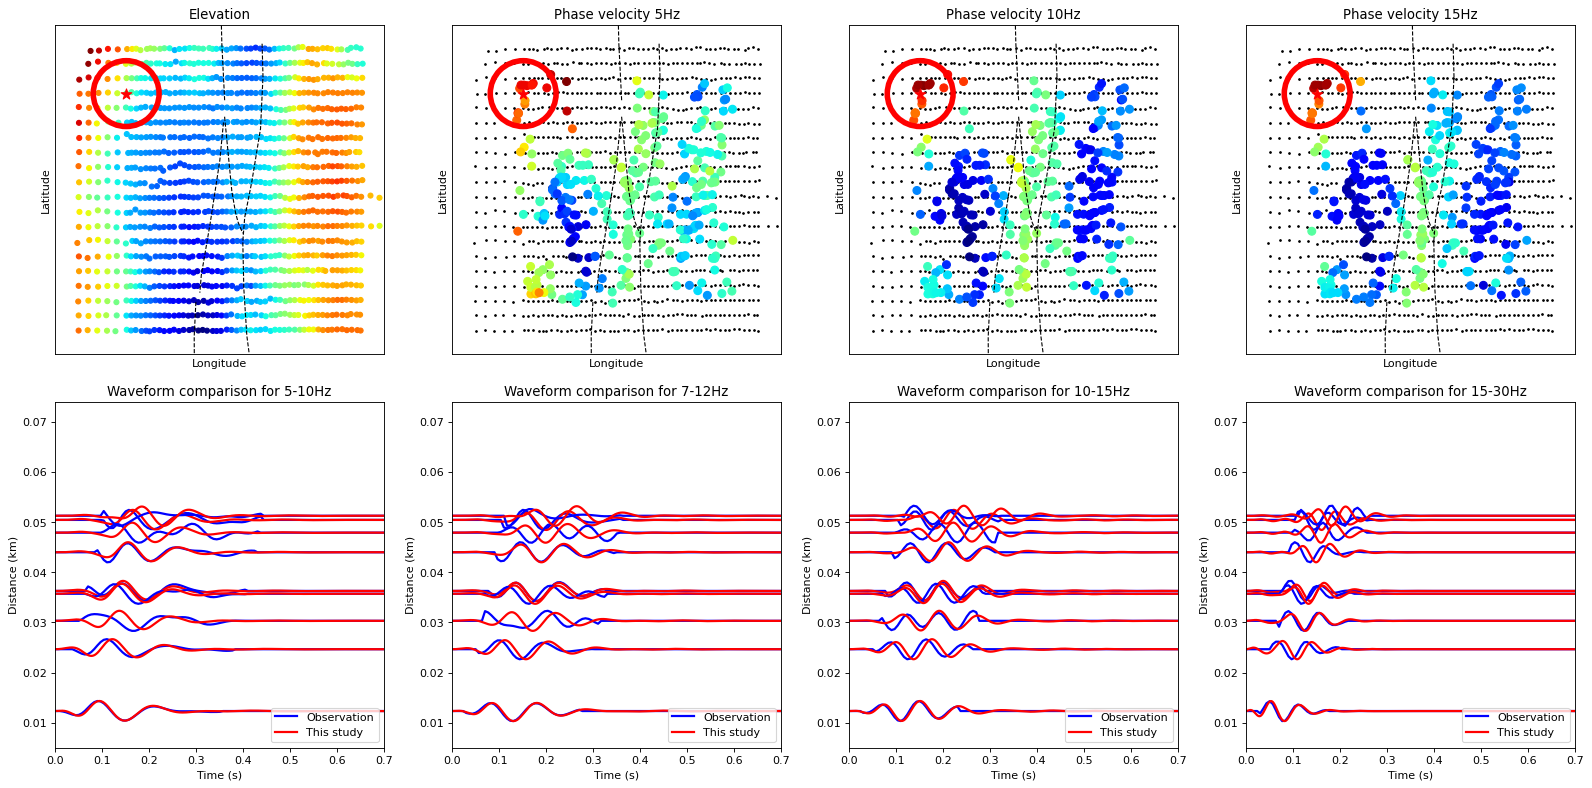

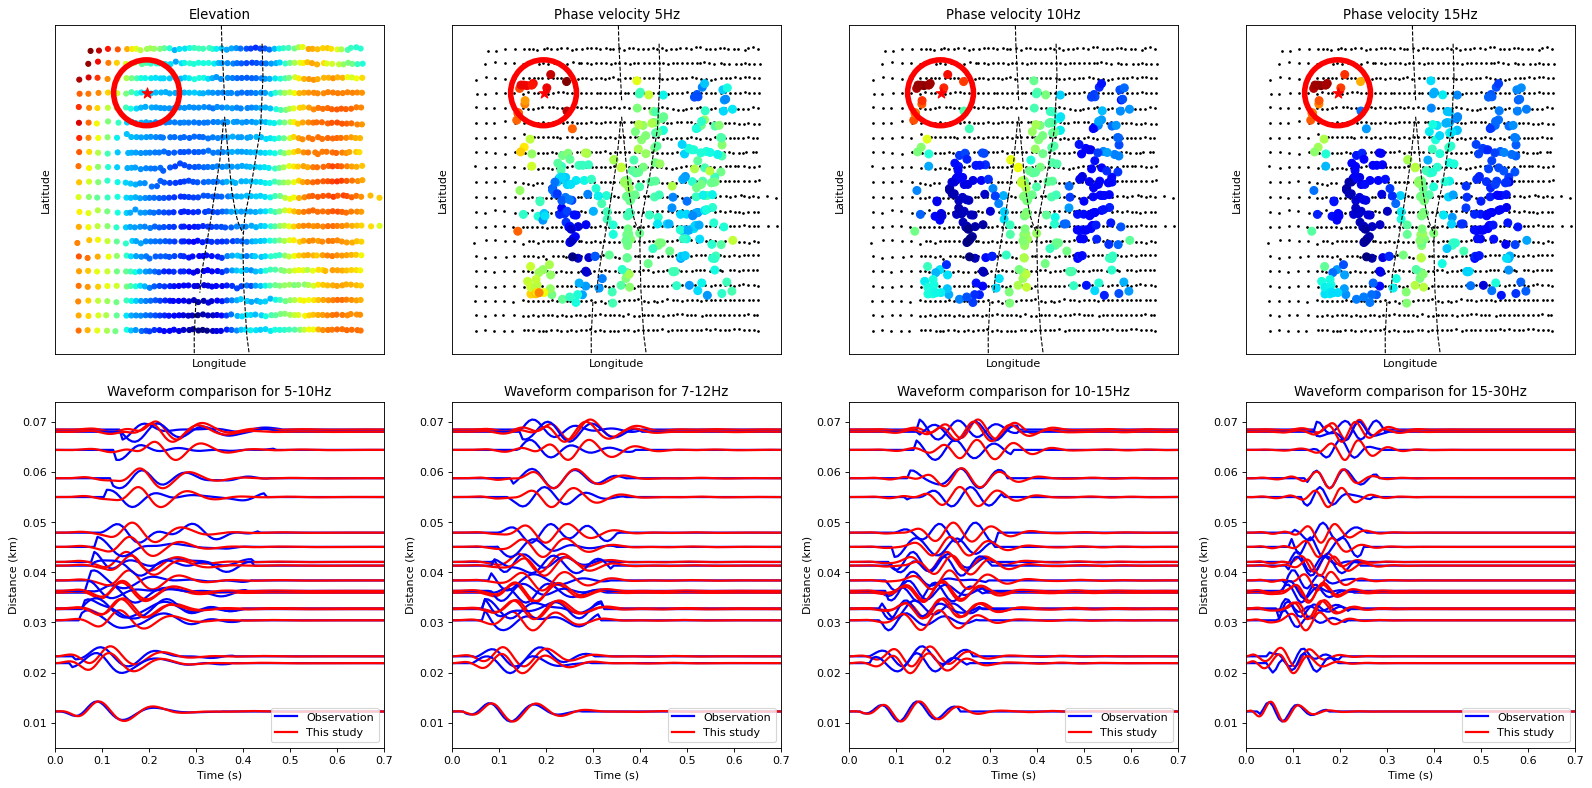

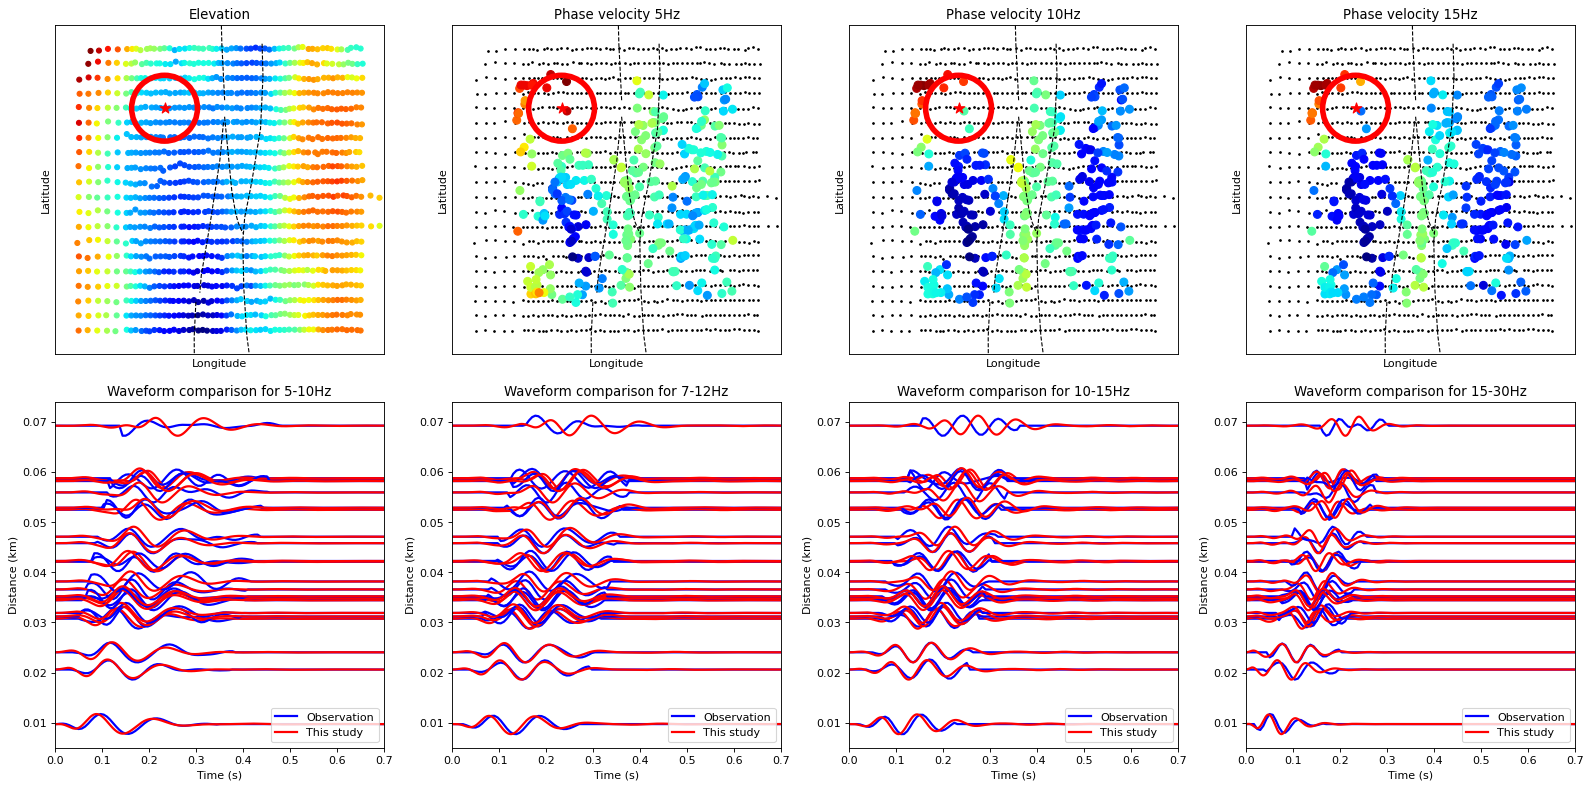

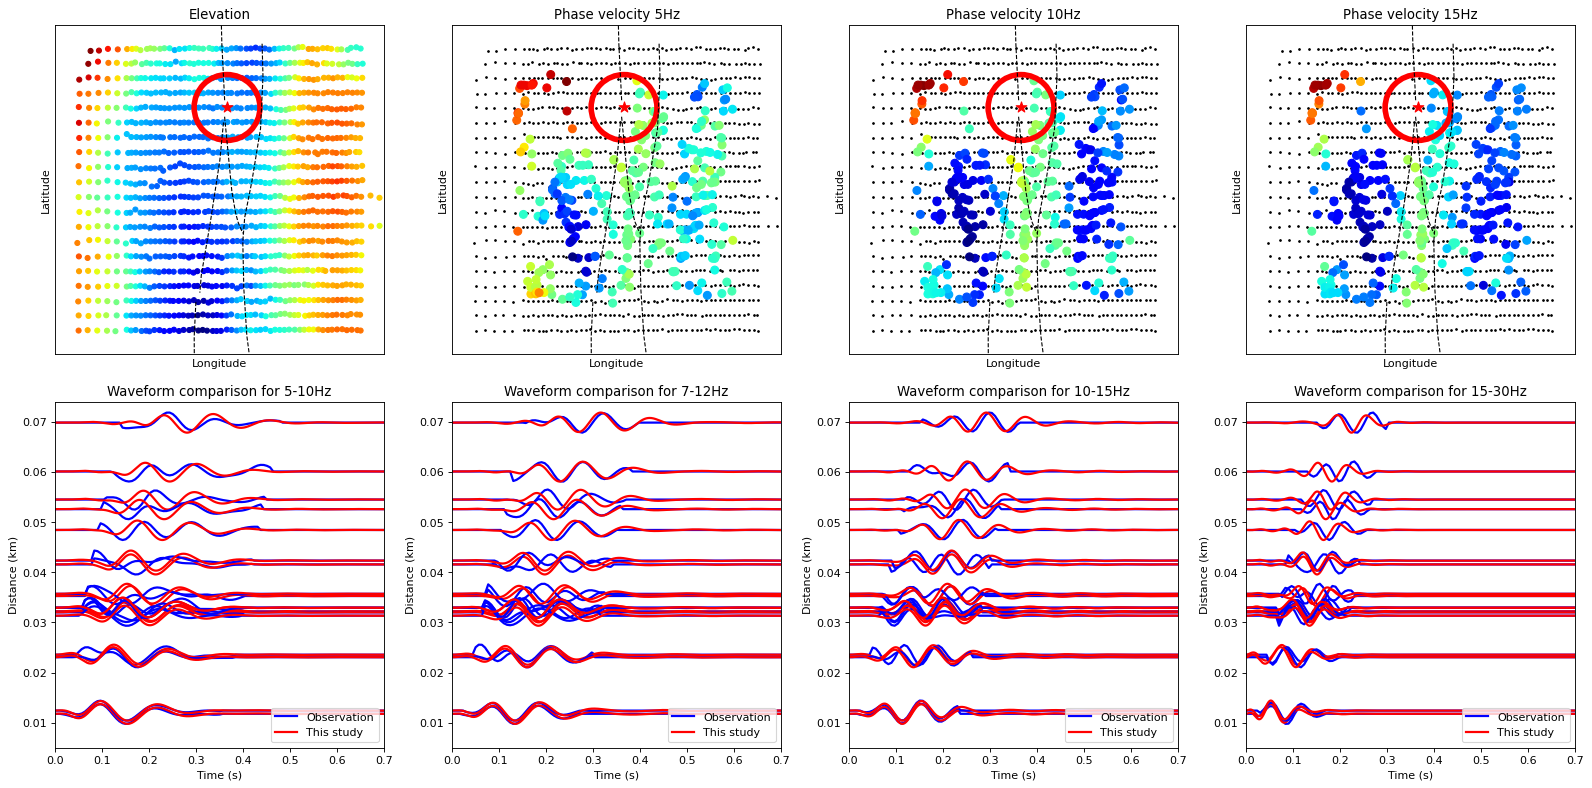

In [85]:
for isrc in range(53,57):
    dir_src = dir_project + 'ModelValidate/src'+str(isrc)+'/'
    data = np.load(dir_src+'waveform.npy',allow_pickle='TRUE').item()
    wavesync_T = data['wavesync_T']
    waveobsc_T = data['waveobsc_T']
    t = data['t']
    r_plot = data['r_plot']
    flag_inter = 1
    aver = np.array([0.45,0.5,0.5,0.5])
    t_left_shits = np.array([0.01,0,0,0])
    t_right_shits = np.array([0.33,0.25,0.21,0.15])
    plot_model(waveobsc_T,wavesync_T, r_plot, t, dir_image, bands,isrc,flag_inter,aver,t_left_shits,t_right_shits,faults)
    #plot_model(waveobsc_T,wavesync_T, r_plot, t, dir_image, bands,isrc,flag_inter,aver,t_left_shits,t_right_shits,faults)